In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
from nbodykit.lab import *
from nbodykit import style, setup_logging
setup_logging()
import matplotlib.pyplot as plt
plt.style.use(style.notebook)

### Make LogNormal galaxy catalog with RSD

In [3]:
redshift = 0.55
cosmo = cosmology.Planck15
b1 = 2.0
Plin = cosmology.LinearPower(cosmo, redshift, transfer="EisensteinHu")

cat = LogNormalCatalog(Plin=Plin, nbar=3e-4, BoxSize=1380., Nmesh=256, bias=b1, seed=42)

# add RSD
LOS = [0,0,1]
cat['RSDPosition'] = cat['Position'] + cat['VelocityOffset']*LOS 

[ 000018.27 ]   0: 06-16 13:56  LogNormalCatalog INFO     Growth Rate is 0.770123
[ 000018.27 ]   0: 06-16 13:56  LogNormalCatalog INFO     Generating whitenoise
[ 000021.34 ]   0: 06-16 13:56  LogNormalCatalog INFO     Write noise generated
[ 000022.70 ]   0: 06-16 13:56  LogNormalCatalog INFO     Displacement computed in fourier space
[ 000023.29 ]   0: 06-16 13:56  LogNormalCatalog INFO     Overdensity computed in configuration space: std = 1.1929580837889608
[ 000024.88 ]   0: 06-16 13:56  LogNormalCatalog INFO     Displacement computed in configuration space: std = [4.238011674174512, 4.235169508603116, 4.313347332404491]
[ 000024.89 ]   0: 06-16 13:56  LogNormalCatalog INFO     gaussian field is generated
[ 000026.10 ]   0: 06-16 13:56  LogNormalCatalog INFO     Lognormal transformation done
[ 000028.84 ]   0: 06-16 13:56  LogNormalCatalog INFO     Poisson sampling done, total number of objects is 788095
[ 000057.55 ]   0: 06-16 13:57  LogNormalCatalog INFO     catalog produced. 

Convert `CatalogSource` into `MeshSource`. Use TSC interpolation and compensate for interpolation effects in Fourier space. This mesh will be used for all following power spectra.

In [ ]:
mesh = cat.to_mesh(window='tsc', Nmesh=256, compensated=True, position='RSDPosition')

### Find 1D power spectrum $P(k)$

In [51]:
r = FFTPower(mesh, mode='1d', dk=0.005, kmin=0.01)
Pk = r.power

[ 002812.46 ]   0: 06-16 14:43  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 788095 
[ 002814.06 ]   0: 06-16 14:43  CatalogMesh     INFO     painted 788095 out of 788095 objects to mesh
[ 002814.07 ]   0: 06-16 14:43  CatalogMesh     INFO     painted 788095 out of 788095 objects to mesh
[ 002814.07 ]   0: 06-16 14:43  CatalogMesh     INFO     mean particles per cell is 0.0469741
[ 002814.07 ]   0: 06-16 14:43  CatalogMesh     INFO     sum is 788095 
[ 002814.09 ]   0: 06-16 14:43  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 002814.34 ]   0: 06-16 14:43  CatalogMesh     INFO     field: (LogNormalCatalog(seed=42, bias=2) as CatalogMesh) painting done


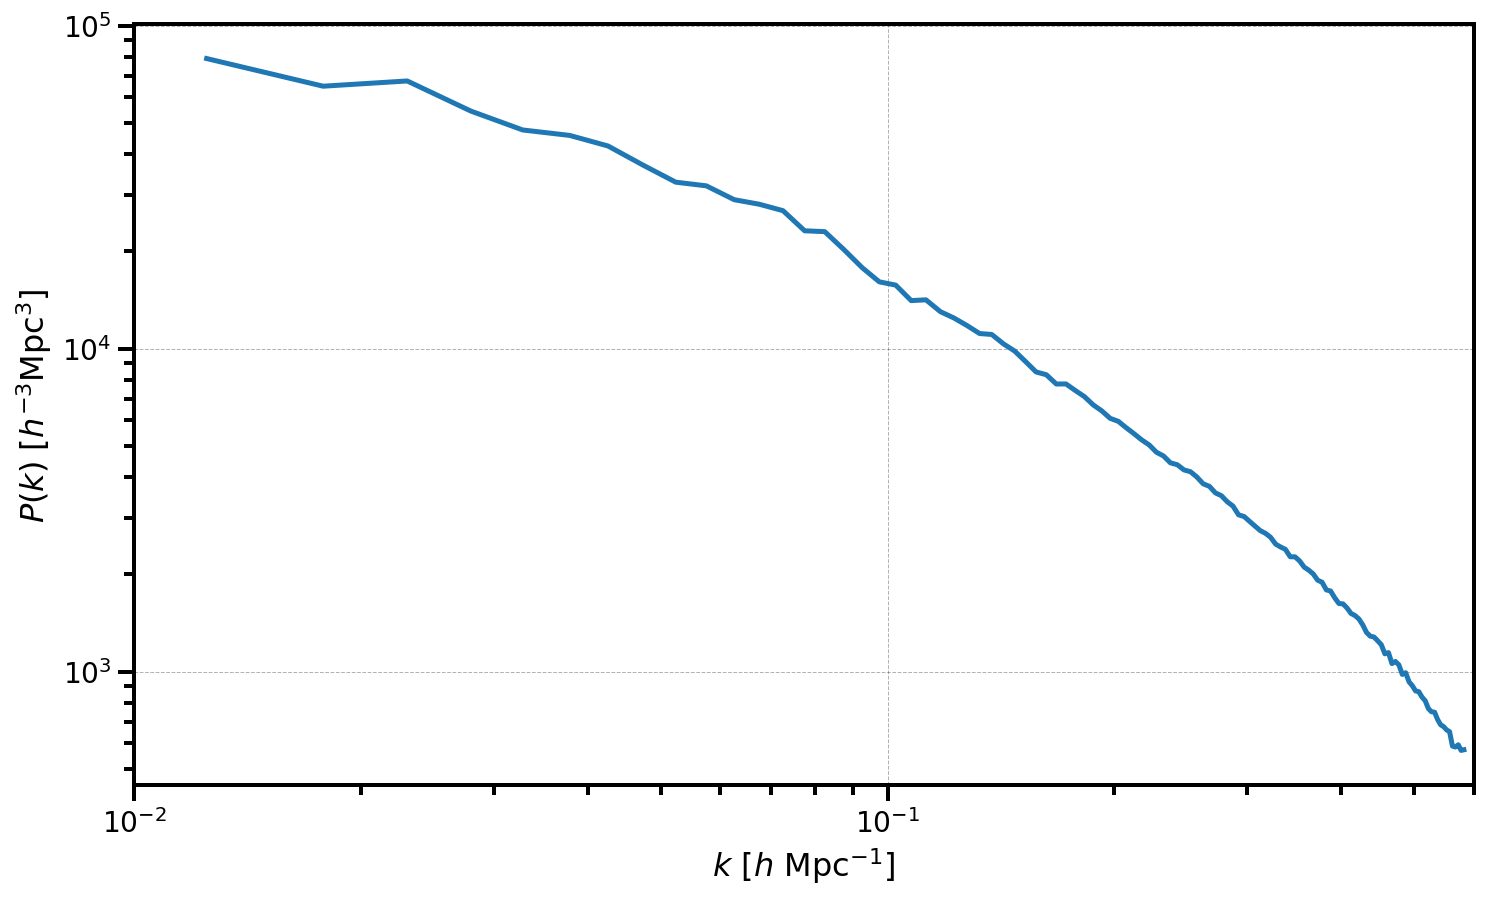

In [5]:
plt.loglog(Pk['k'], Pk['power'].real - Pk.attrs['shotnoise'])

plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.6)
plt.show()

### Find 2D power spectrum $P(k, \mu)$
Issue of $\mu \in [-1,1]$, rather than $[0,1]$ persists, as addressed in LogNormal notebook and is GitHub issue 663.

To get the isotropic power as a function of $\mu$, change `los` in `FFtTPower` to for example `[1,0,0]`.

In [24]:
r = FFTPower(mesh, mode='2d', dk=0.005, kmin=0.01, Nmu=5, los=LOS)
Pkmu = r.power

[ 000440.35 ]   0: 06-16 14:03  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 788095 
[ 000440.99 ]   0: 06-16 14:03  CatalogMesh     INFO     painted 788095 out of 788095 objects to mesh
[ 000441.00 ]   0: 06-16 14:03  CatalogMesh     INFO     painted 788095 out of 788095 objects to mesh
[ 000441.00 ]   0: 06-16 14:03  CatalogMesh     INFO     mean particles per cell is 0.0469741
[ 000441.01 ]   0: 06-16 14:03  CatalogMesh     INFO     sum is 788095 
[ 000441.03 ]   0: 06-16 14:03  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000441.33 ]   0: 06-16 14:03  CatalogMesh     INFO     field: (LogNormalCatalog(seed=42, bias=2) as CatalogMesh) painting done


/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


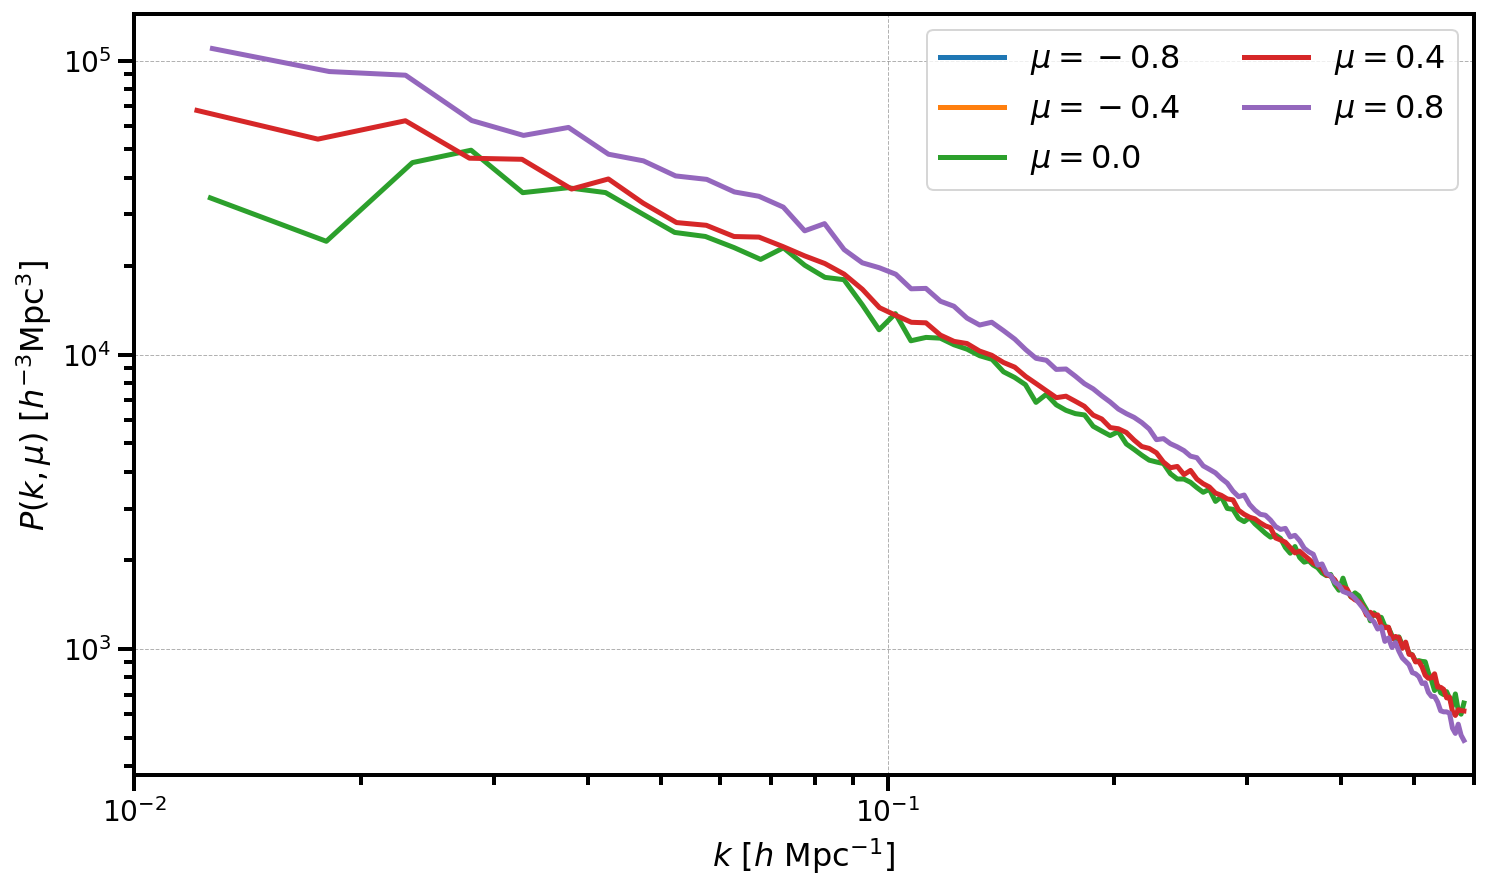

In [38]:
# make graph for every mu i.e for every column of Pkmu
for i in range(Pkmu.shape[1]):
    Pk = Pkmu[:,i]
    mu = Pkmu.coords['mu'][i]
    label = "$\mu={:.1f}$".format(mu)
    plt.loglog(Pk['k'], Pk['power'] - Pk.attrs['shotnoise'], label=label)

plt.legend(loc=0, ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k, \mu)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.6)
plt.show()

### Find multipoles $P_l(k)$
Mulitpoles are projections of 2D power spectrum on the basis of spherical harmonics. Due to symmetry arguments (Hamilton review, section 5.2) these reduce to Legendre polynomials. To get multipoles, use keyword `poles` in `FFTPower`. This causes `r` to carry the attribute `poles` alongside `power`. Both behave similar. 

A list of all multipole related data can be viewed via `poles.variables`. 

In [39]:
r = FFTPower(mesh, mode='2d', dk=0.005, kmin=0.01, Nmu=5, los=LOS, poles=[0,2,4])
poles = r.poles

[ 001577.16 ]   0: 06-16 14:22  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 788095 
[ 001578.71 ]   0: 06-16 14:22  CatalogMesh     INFO     painted 788095 out of 788095 objects to mesh
[ 001578.72 ]   0: 06-16 14:22  CatalogMesh     INFO     painted 788095 out of 788095 objects to mesh
[ 001578.72 ]   0: 06-16 14:22  CatalogMesh     INFO     mean particles per cell is 0.0469741
[ 001578.72 ]   0: 06-16 14:22  CatalogMesh     INFO     sum is 788095 
[ 001578.73 ]   0: 06-16 14:22  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 001578.99 ]   0: 06-16 14:22  CatalogMesh     INFO     field: (LogNormalCatalog(seed=42, bias=2) as CatalogMesh) painting done


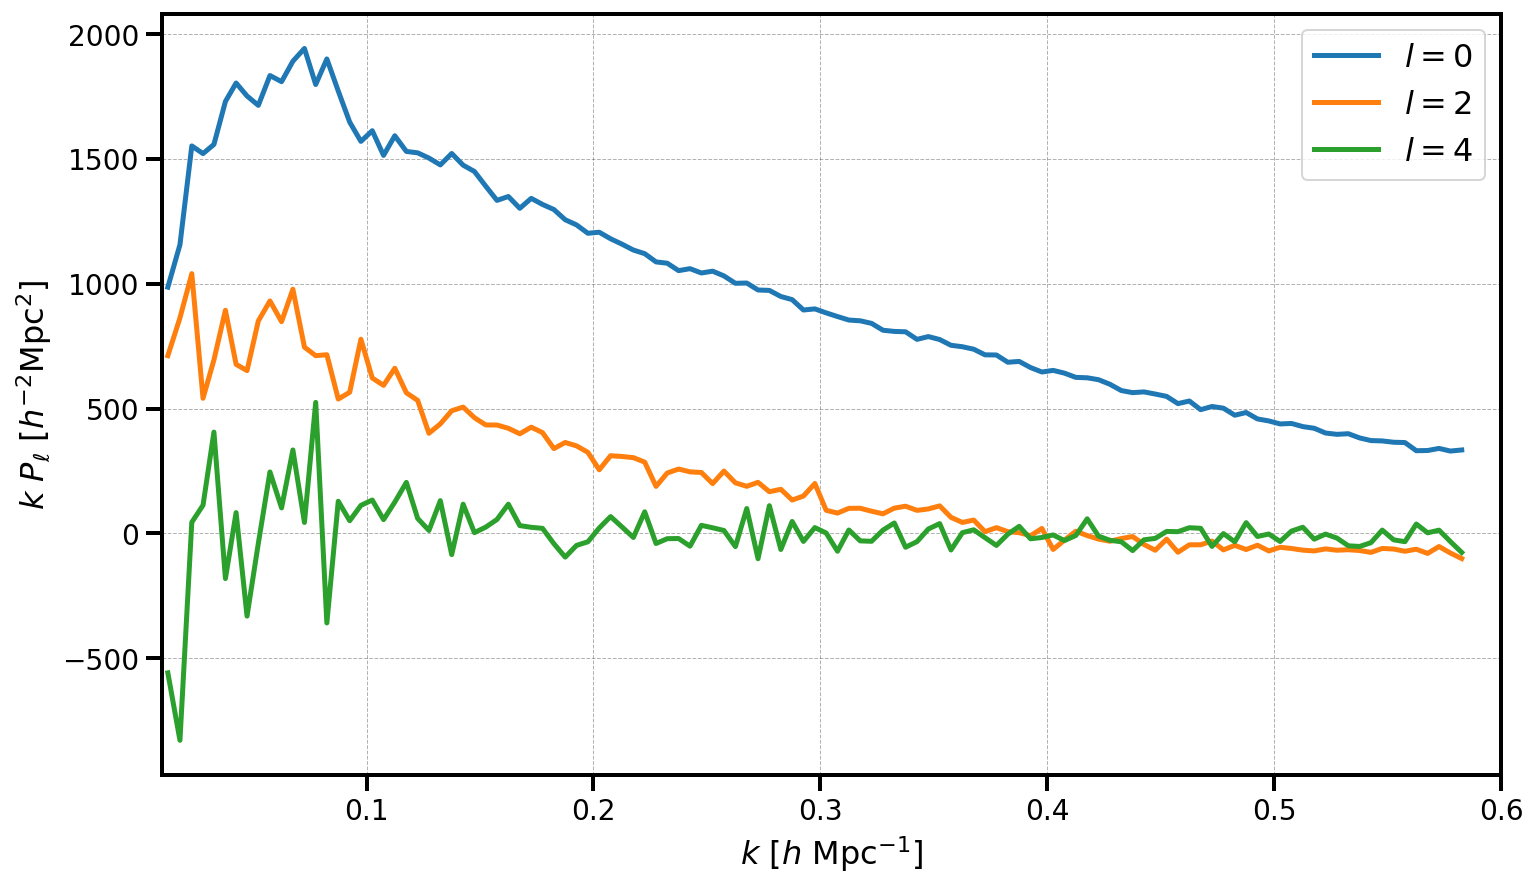

In [50]:
for l in [0,2,4]:
    P = poles['power_{:d}'.format(l)].real
    if l == 0:
        P = P - poles.attrs['shotnoise']
    label = "$l={:d}$".format(l)
    plt.plot(poles['k'], poles['k']*P, label=label)
    
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$k \ P_\ell$ [$h^{-2} \mathrm{Mpc}^2$]")
plt.xlim(0.01, 0.6)
plt.show()